In [7]:
import pandas as pd
import numpy as np
from collections import Counter # used for counting the occurrences of elements in a collection.

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import seaborn as sea
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering #hierarchical
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score #evaluate the quality of a clustering by calculating the Calinski-Harabasz Index
from tabulate import tabulate #pretty-print tabular data.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
import warnings
import os
warnings.filterwarnings("ignore")



## 1- Exploratory Data Analysis

In [8]:
df = pd.read_csv(r'C:\Users\haifa\Albayrak Internship\Projects\Mall Customer Segmentation\Data.csv')

In [9]:
df.shape

(200, 5)

In [10]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [11]:
#Rename columns
df.rename(columns={'Annual Income (k$)' : 'Income','Spending Score (1-100)':'Spending_Score'}, inplace=True)

In [12]:
df.head()

,CustomerID,Gender,Age,Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Income          200 non-null    int64 
 4   Spending_Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


We can notice that there are no null values in our data, which we will make sure more about it later.

In [14]:
df.describe()

,CustomerID,Age,Income,Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 2- Data Preprocessing

In [15]:
# Check for missing values
df.isnull().sum()

CustomerID        0
Gender            0
Age               0
Income            0
Spending_Score    0
dtype: int64

<Axes: >

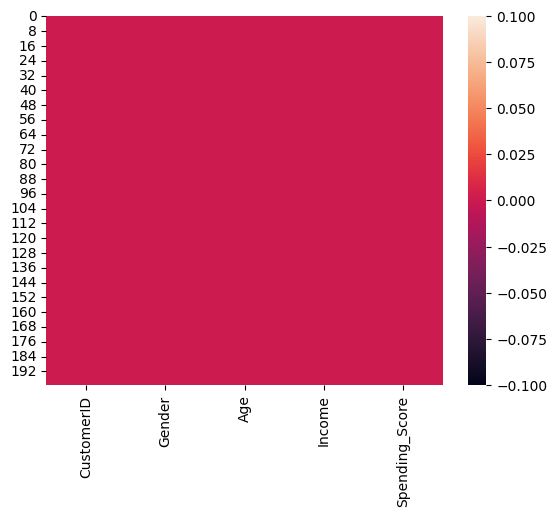

In [16]:
sns.heatmap(df.isnull())

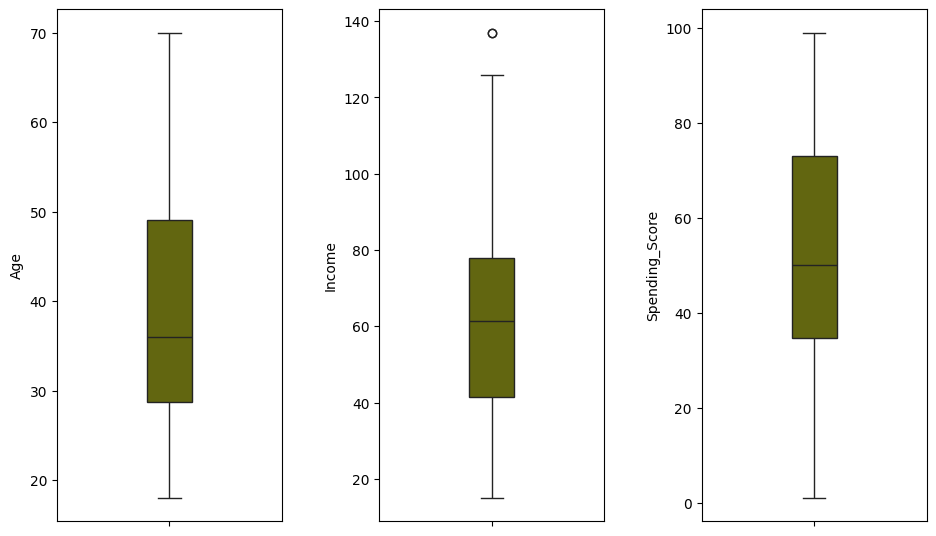

In [17]:
#Outlier check with IQR
numerical_features = ['Age', 'Income', 'Spending_Score']
fig, axes = plt.subplots(1, 3, figsize=(10,6))
for i, feature in enumerate(numerical_features):
    sea.boxplot(y=df[feature], orient="v", color = "#6f7501", width = 0.2, ax=axes[i])
    
fig.tight_layout(pad=3.0)

In [18]:
def detect_outliers(df, n, features_list):
    outlier_indices = [] 
    for feature in features_list: 
        #Calculate Q1, Q3, and IQR
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        #Identify Outliers:
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
        
    #Count the Occurrences of Each Outlier:
    outlier_indices = Counter(outlier_indices)
    #Filter Out Multiple Outliers:
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

outliers_to_drop = detect_outliers(df, 2, ['Age', 'Income', 'Spending_Score'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 0 indices:  []


In [19]:
# Drop the outliers from the DataFrame
df_cleaned = df.drop(outliers_to_drop, axis=0).reset_index(drop=True)
print(df_cleaned.shape)

(200, 5)


In [20]:
#Drop customer ID because no need for it later
df.drop(['CustomerID'], axis = 1, inplace = True)

In [21]:
df

,Gender,Age,Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


## 3- visualizations

In [22]:
#Gender Distribution
genders= df.Gender.value_counts()
genders

Gender
Female    112
Male       88
Name: count, dtype: int64

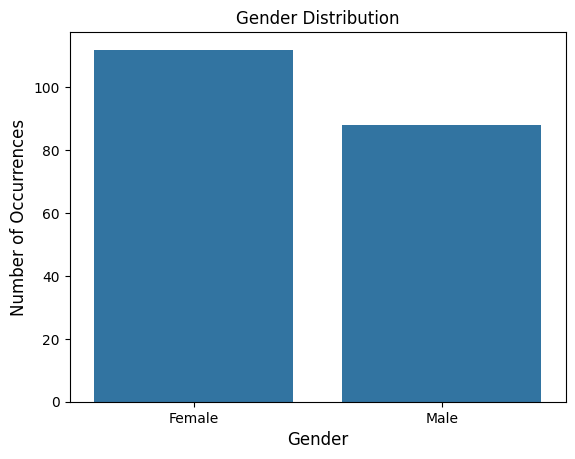

In [23]:
sns.barplot(x=genders.index, y=genders.values,)
plt.title('Gender Distribution')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Gender', fontsize = 12)
plt.show()

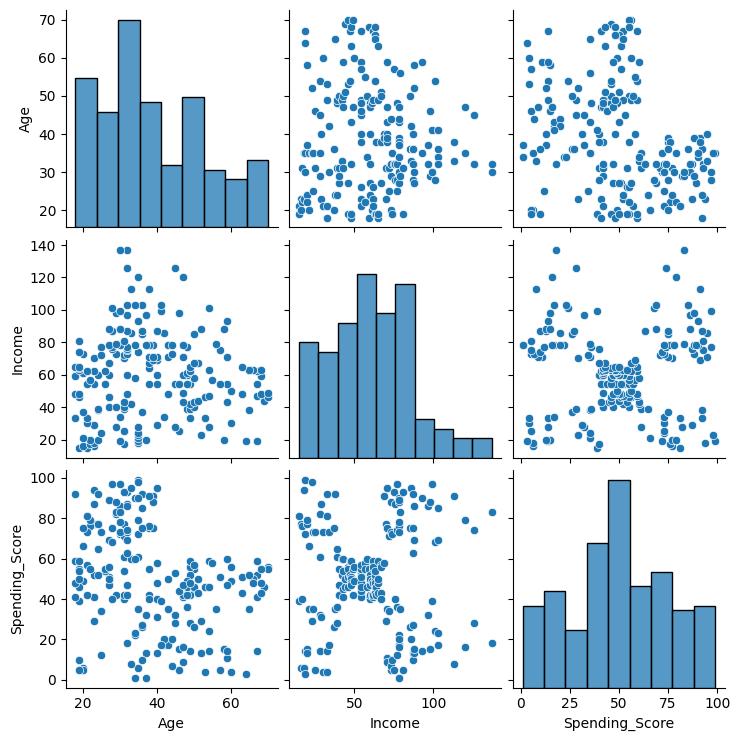

In [24]:
#Numerical features distribution
sns.pairplot(df[numerical_features])
plt.show()

In [25]:
## Mean Spending Score by Gender
gender_score = df[['Gender', 'Spending_Score']].groupby('Gender', as_index = False).mean()
gender_score

,Gender,Spending_Score
0,Female,51.526786
1,Male,48.511364


In [26]:
#Age vs Annual Income
fig = px.scatter(df, x='Age', y='Income', color='Gender')
fig.update_layout(title='Age vs Annual Income')
fig.show()

In [27]:
#Age vs Spending Score
fig = px.scatter(df, x='Age', y='Spending_Score', color='Gender')
fig.update_layout(title='Age vs Spending Score')
fig.show()

In [28]:
#Annual Income vs Spending Score
fig = px.scatter(df, x='Income', y='Spending_Score', color='Gender')
fig.update_layout(title='Annual Income vs Spending Score')
fig.show()

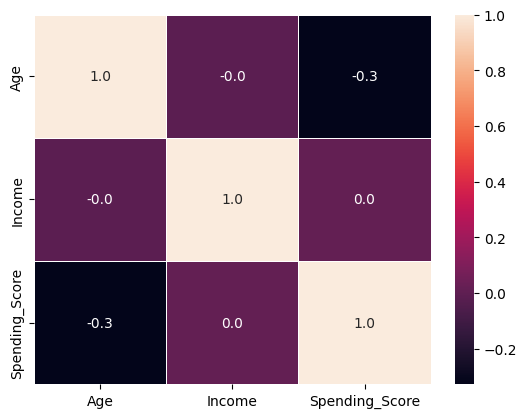

In [29]:
#correlation
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt ='.1f',linewidth= .5)
plt.show()

## 4- Feature Engineering

In [30]:
for column in df.columns:
    
    print("Feature name: {}".format(column))
    print("Unique values:")
    print(df[column].unique())
    print("--------------------------------------------------\n")

Feature name: Gender
Unique values:
['Male' 'Female']
--------------------------------------------------

Feature name: Age
Unique values:
[19 21 20 23 31 22 35 64 30 67 58 24 37 52 25 46 54 29 45 40 60 53 18 49
 42 36 65 48 50 27 33 59 47 51 69 70 63 43 68 32 26 57 38 55 34 66 39 44
 28 56 41]
--------------------------------------------------

Feature name: Income
Unique values:
[ 15  16  17  18  19  20  21  23  24  25  28  29  30  33  34  37  38  39
  40  42  43  44  46  47  48  49  50  54  57  58  59  60  61  62  63  64
  65  67  69  70  71  72  73  74  75  76  77  78  79  81  85  86  87  88
  93  97  98  99 101 103 113 120 126 137]
--------------------------------------------------

Feature name: Spending_Score
Unique values:
[39 81  6 77 40 76 94  3 72 14 99 15 13 79 35 66 29 98 73  5 82 32 61 31
 87  4 92 17 26 75 36 28 65 55 47 42 52 60 54 45 41 50 46 51 56 59 48 49
 53 44 57 58 43 91 95 11  9 34 71 88  7 10 93 12 97 74 22 90 20 16 89  1
 78 83 27 63 86 69 24 68 85 23  8 18]
--

- Label Encoding

In [31]:
df_tr=df.copy()
label_encoding_columns = ['Gender']
for column in label_encoding_columns:
    if column =='Gender':
        df_tr[column]=df_tr[column].map({'Female': 1, 'Male': 0})

- Feature Scaling Normalization

here we are going to transform numerical data to a common scale. After normalization, all variable have similar influence on model, improving the stability and performance of the algo. Here we are going tı use min-max approach, which rescales the feature to a fixed range [0 , 1] by substructing min from max, then divide by the range

In [32]:
min_max_columns = ['Spending_Score','Income']
for column in min_max_columns:
    min_column = df_tr[column].min()
    max_column = df_tr[column].max()
    #min max scaler
    df_tr[column] = (df_tr[column]- min_column)/(max_column - min_column)

## 5- Determine the Optimal Number of Clusters

- Select features for clustering

In [33]:
X = df[['Income', 'Spending_Score']]

- Standardize the data

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## A) Elbow Method

- Run cluster analysis as 1 till 12, we store WCSS stores. This WSS will help us in elbow method to find optimal number of clusters

- WCSS : within-cluster-sum-squared

In [35]:
K = range(1,12)
wcss = []
for i in K:
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

  File "c:\Users\haifa\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [36]:
#store number of clusters along with their wcss
mycenters = pd.DataFrame({'Clusters ' : K, 'WCSS' : wcss})
mycenters

,Clusters,WCSS
0,1,269981.280000
1,2,183653.328947
2,3,106348.373062
3,4,73880.644962
4,5,44448.455448
5,6,40825.169464
6,7,33642.579221
7,8,26686.837785
8,9,24766.471610
9,10,23103.122086


- Plot the elbow method 

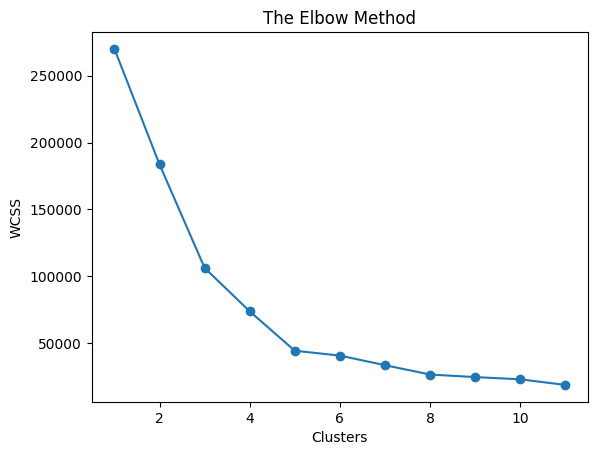

In [37]:
plt.plot(range(1, 12), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

- Here we can notice that the optimal number of clustering is 5

## B) Silhouette Score Analysis

- Measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 to 1, where a higher value indicates better-defined clusters:
- The silhouette score measures how similar an object is to its own cluster compared to other clusters. For this metric to be meaningful, you need at least two clusters because it compares the average distance between clusters and within clusters.

In [38]:
for i in range(2,13):
    labels = KMeans(n_clusters = i, init = 'k-means++', random_state = 42).fit(X).labels_
    print("Silhouette Score fo k(clusters) =" +str(i) +" is " +str(metrics.silhouette_score(X,labels,metric="euclidean", sample_size =1000,random_state = 42)))

Silhouette Score fo k(clusters) =2 is 0.39564531743995546
Silhouette Score fo k(clusters) =3 is 0.46761358158775423
Silhouette Score fo k(clusters) =4 is 0.49379458143541166
Silhouette Score fo k(clusters) =5 is 0.553931997444648
Silhouette Score fo k(clusters) =6 is 0.512840532800438
Silhouette Score fo k(clusters) =7 is 0.5017174409749505
Silhouette Score fo k(clusters) =8 is 0.4962769338093322
Silhouette Score fo k(clusters) =9 is 0.45587414130065596
Silhouette Score fo k(clusters) =10 is 0.4426214845978157
Silhouette Score fo k(clusters) =11 is 0.41413838935154096
Silhouette Score fo k(clusters) =12 is 0.3868530059780521


- As we can see ,silhouette score is maximum when k=5, hence we the optimal solution is 5 clusters

## 6- K-means Clustering

In [39]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
# fitting the input data
kmeans.fit(X)

# predicting the labels of the input data
y_kmeans= kmeans.predict(X)

# adding the labels to a column named label
df["label"] = y_kmeans

df.head()

,Gender,Age,Income,Spending_Score,label
0,Male,19,15,39,4
1,Male,21,15,81,2
2,Female,20,16,6,4
3,Female,23,16,77,2
4,Female,31,17,40,4


- Visualize the clusters in 2D and 3D plots

In [40]:
df['Clusters'] =kmeans.labels_

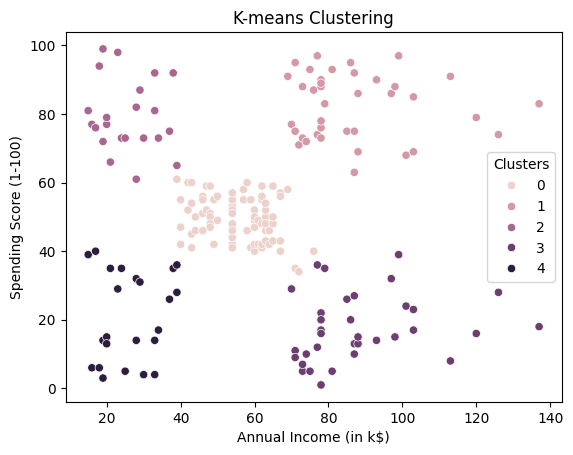

In [41]:
sns.scatterplot(x='Income',y='Spending_Score', hue ='Clusters', data=df)
centers = kmeans.cluster_centers_
plt.xlabel('Annual Income (in k$)')
plt.ylabel('Spending Score (1-100)') 
plt.title('K-means Clustering')
plt.show()

- Analyze the characteristics of each cluster

From the above graph, we can see that there are 5 clusters.
- Medium Income - Medium Score customers:customers have an income range of 40 - 80 and have a spending score in the range of 40 - 60.
- High Income - High Score customers: customers have an income range of > 70 and have a spending score of greater than 60.
- Low Income - High Score customers: customers have an income range of < 40 and have a spending score of greater than 60.
- High Income - Low Score customers: customers have an income range of > 65 and have a spending score of less than 40.
- Low Income - Low Score customers: customers have an income range of < 40 and have a spending score of less than 40.

The aim of the mall is to increase the customers present in the cluster 'High Income - High Score' by reducing the customers present in the cluster 'High Income - Low Score' and also to migrate the customers present in the cluster 'Medium Income - Medium Score' to higher spending scores

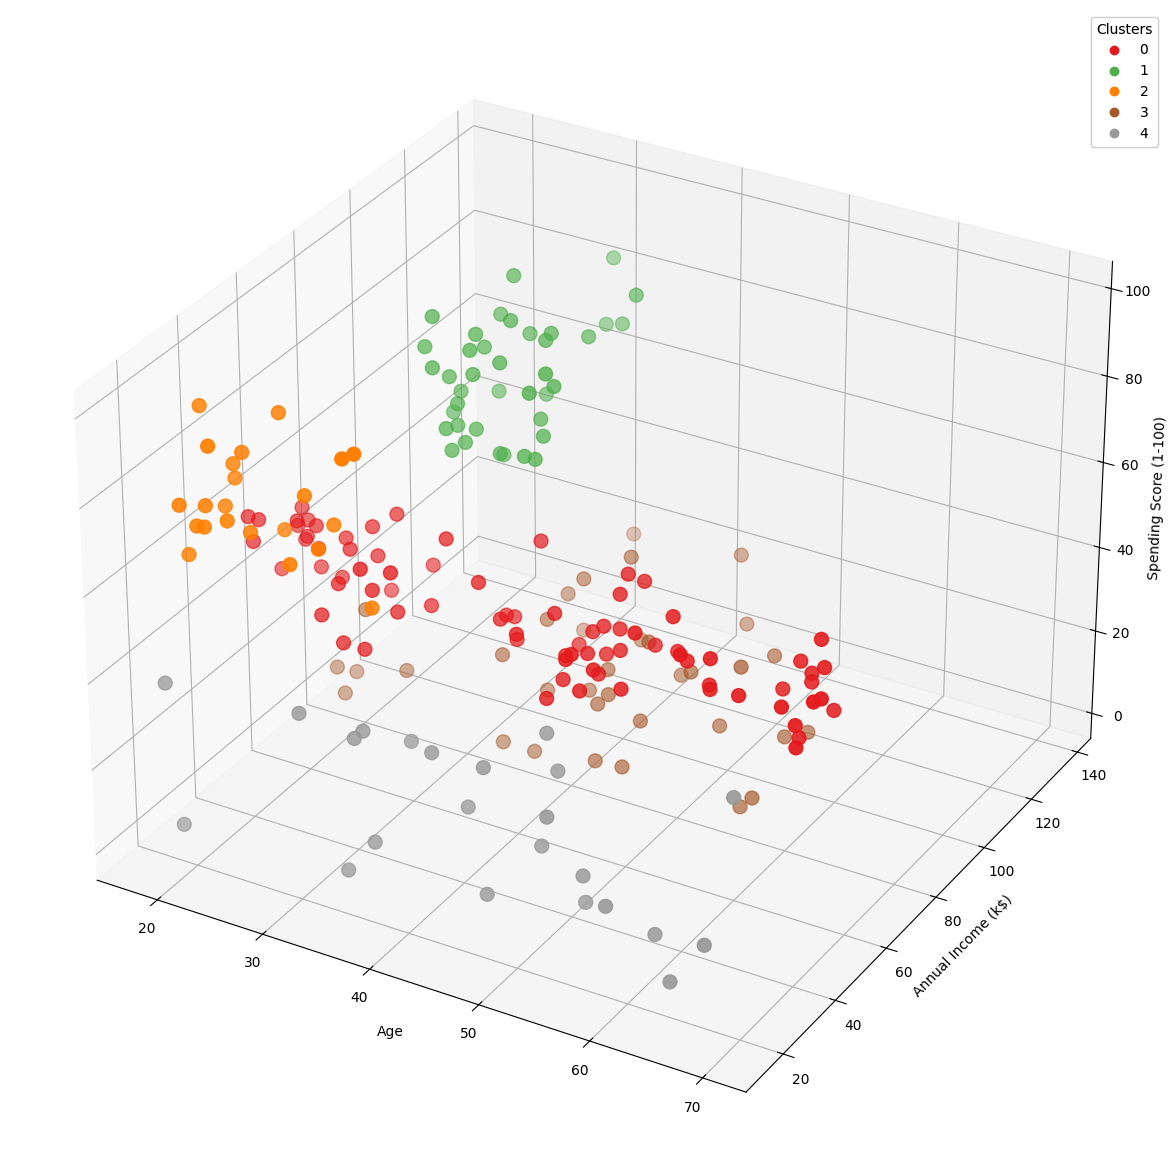

In [42]:
### Visualizing 3D the clusters
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Use ax.scatter with explicit x, y, z coordinates and color based on clusters
sc = ax.scatter(df['Age'], df['Income'], df['Spending_Score'],
                c=df['Clusters'], cmap='Set1', s=100)

# Label axes
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')

# Add legend
legend1 = ax.legend(*sc.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

- Principal Component Analysis (PCA) 

PCA reduces the number of dimensions (features) in the dataset while retaining as much variance (information) as possible. This simplifies the dataset, making it easier to visualize and analyze.

Why Use PC1 and PC2? In the context of PCA, PC1 (Principal Component 1) and PC2 (Principal Component 2) represent the directions in the feature space along which the data varies the most. Here’s why we use them: Maximum Variance, Feature Independence, Dimensionality Reduction

Why Plot PC1 vs. PC2? When we plot PC1 vs. PC2, we are projecting the high-dimensional data onto a 2D plane defined by the first two principal components. This allows us to:
Visualize Clusters: Identify clusters or groupings in the data that might not be apparent in the original high-dimensional space

In [43]:
# Ensure df has the necessary columns: 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'
features = ['Age', 'Income', 'Spending_Score']
x = df[features].values
x = StandardScaler().fit_transform(x)

In [44]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


In [45]:
# Fit KMeans on the PCA-transformed data
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df)

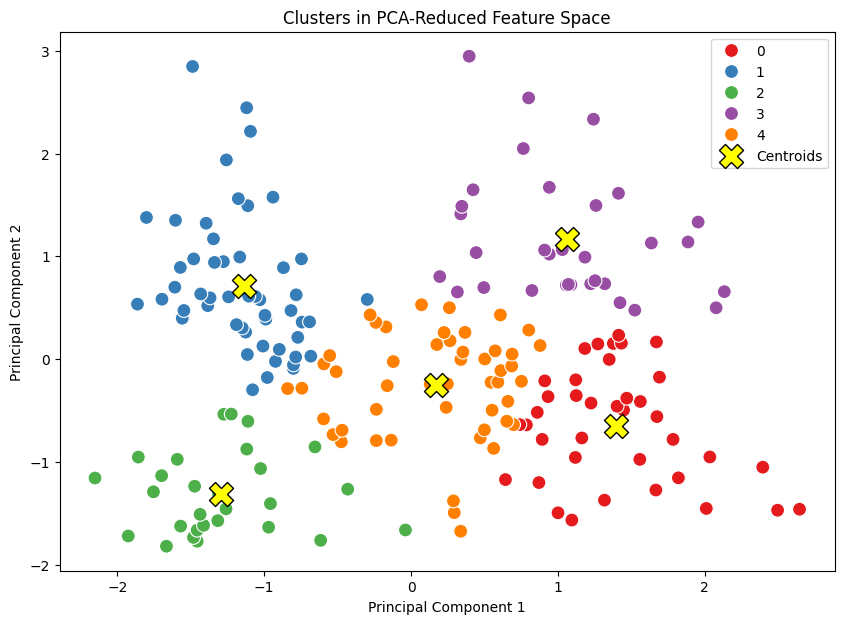

In [46]:
# Visualize the clusters in the reduced feature space
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set1', s=100)
# Adding cluster centers to the plot
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='yellow', edgecolor='black', marker='X', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters in PCA-Reduced Feature Space')
plt.legend()
plt.show()

## 7- Hierarchical Clustering 

In [47]:
X = df[['Income', 'Spending_Score']].iloc[:, :].values #results in the same DataFrame as before, containing all rows and columns of the selected subset.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

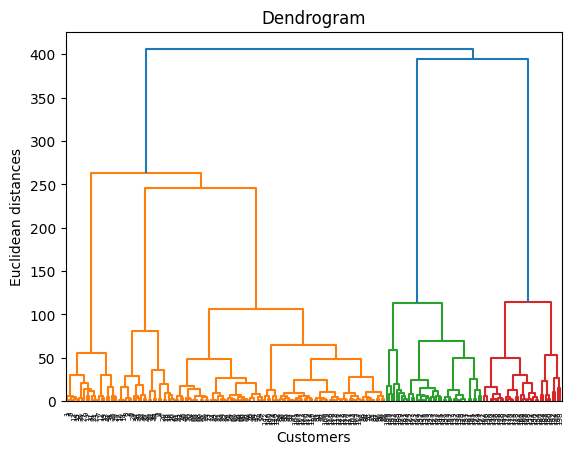

In [48]:
### Using the dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

We can notice here that we have 3 clusters as optimal number

In [49]:
### Training the Hierarchial clustering model on the dataset
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_hc = hc.fit_predict(X)

In [50]:
df['Cluster'] = y_hc

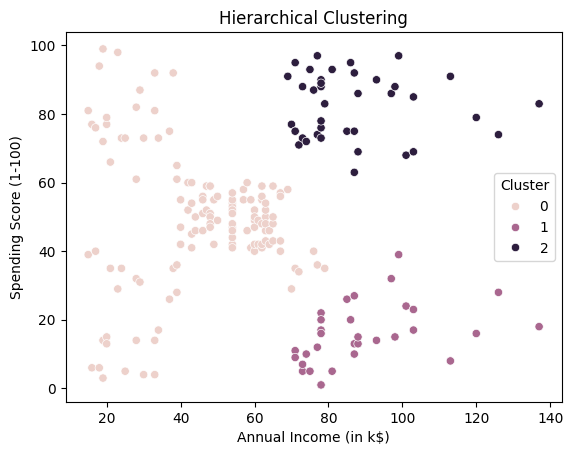

In [51]:
sns.scatterplot(x='Income',y='Spending_Score', hue ='Cluster', data=df)
plt.xlabel('Annual Income (in k$)')
plt.ylabel('Spending Score (1-100)') 
plt.title('Hierarchical Clustering')
plt.show()

From the above graph, we can see that there are 3 clusters.
- Low-Medium Income customers: customers belong low to medium income groups.
- High Income-Low Score customers: customers have an income group of > 70 and have a low spending score of < 40.
- High Income-High Score customers: customers have an income group of > 70 and have a high spending score of > 60.

The aim of the mall should be to increase the customers present in the cluster 'High Income - High Score customers' by reducing the customers present in the cluster 'High Income - Low Score customers' and also to make efforts to increase the Spending Score of the customers present in the cluster 'Low - Medium Income customers'

## 8- Compare the results with K-means clustering

In [52]:
## Calculate the Silhouette Score for Kmeans clustering model
score1 = silhouette_score(X, y_kmeans)
print("Silhouette Score:", score1)

Silhouette Score: 0.553931997444648


In [53]:
## Calculate the Silhouette Score for Hierarchial clustering model
score2 = silhouette_score(X, y_hc)
print("Silhouette Score:", score2)

Silhouette Score: 0.4618340266628975


  - we can see that K-Means performs better than Hierarchial clustering on comparing the Silhouette score, A higher Silhouette Score indicates better clustering because it shows that data points are both well-clustered and well-separated from other clusters.

- The Silhouette Score is a metric used to evaluate the quality of clustering. It measures how similar an object is to its own cluster compared to other clusters. The score is calculated for each data point and then averaged to provide an overall assessment of clustering quality.
- The Silhouette Score ranges from -1 to 1:
1: Indicates that the data point is well-clustered and very similar to points in its own cluster, while being very dissimilar to points in other clusters.
0: Indicates that the data point is on or very close to the decision boundary between two neighboring clusters.
-1: Indicates that the data point is incorrectly clustered, meaning it is closer to points in another cluster than to points in its own cluster.